# Getting embeddings:
Download this repository and point the following variable to the repo root
https://github.com/siliconjungle/vector-embeddings-english-dictionary/tree/main

In [1]:
embeddings_folder = "/Users/francescogentile/Documents/Gamedev/vector-embeddings-english-dictionary-main"

In [8]:
import json
import os
import numpy as np

In [246]:
print(f"{embeddings_folder}/lookup.json")
with open(f"{embeddings_folder}/lookup.json") as f:
  lookup = json.load(f)

print(lookup["aa"])
print(len(lookup.values()))
print(list(lookup.values())[-2])

/Users/francescogentile/Documents/Gamedev/vector-embeddings-english-dictionary-main/lookup.json
{'fileName': 'embeddings/embeddings_1.json', 'index': 0}
274401
{'fileName': 'embeddings/embeddings_275.json', 'index': 409}


In [317]:
with open(f"{embeddings_folder}/{lookup['aa']['fileName']}") as f:
  sample_embedding = json.load(f)[0]
len(sample_embedding["embedding"])

1536

# Setup OpenAI


In [248]:

# Test that your OpenAI API key is correctly set as an environment variable
# Note. if you run this notebook locally, you will need to reload your terminal and the notebook for the env variables to be live.
import os
import openai
import dotenv
dotenv.load_dotenv()

# Note. alternatively you can set a temporary env variable like this:
# os.environ["OPENAI_API_KEY"] = 'sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

if os.getenv("OPENAI_API_KEY") is not None:
    openai.api_key = os.getenv("OPENAI_API_KEY")
    print ("OPENAI_API_KEY is ready")
else:
    print ("OPENAI_API_KEY environment variable not found")

OPENAI_API_KEY is ready


# Setup Redis for vector searches

In [249]:

import redis
from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)
from redis.commands.search.query import Query
from redis.commands.search.field import (
    TextField,
    VectorField
)

REDIS_HOST =  "localhost"
REDIS_PORT = 6379

# Connect to Redis
redis_client = redis.Redis(
    host=REDIS_HOST,
    port=REDIS_PORT,
)
redis_client.ping()

True

In [292]:
# Constants
VECTOR_DIM = len(sample_embedding["embedding"]) # length of the vectors
VECTOR_NUMBER = 3000 #len(lookup)                 # initial number of vectors
INDEX_NAME = "dictionary-embeddings"           # name of the search index
PREFIX = "doc"                            # prefix for the document keys
DISTANCE_METRIC = "COSINE"                # distance metric for the vectors (ex. COSINE, IP, L2)

In [293]:
# Define RediSearch fields for each of the columns in the dataset
word = TextField(name="word")
word_embedding = VectorField("word_vector",
    "FLAT", {
        "TYPE": "FLOAT32",
        "DIM": VECTOR_DIM,
        "DISTANCE_METRIC": DISTANCE_METRIC,
        "INITIAL_CAP": VECTOR_NUMBER,
    }
)
fields = [word, word_embedding]

In [294]:
# Check if index exists
try:
    redis_client.ft(INDEX_NAME).info()
    redis_client.ft(INDEX_NAME).dropindex()
except:
    pass
# Create RediSearch Index
redis_client.ft(INDEX_NAME).config_set("VSS_MAX_RESIZE", 52428000000)
redis_client.ft(INDEX_NAME).create_index(
    fields = fields,
    definition = IndexDefinition(prefix=[PREFIX], index_type=IndexType.HASH)
)

b'OK'

Takes 21.2 seconds for 100 words
This would take about 18 hours for the whole dataset, very io bound

In [147]:
def index_documents(client: redis.Redis, prefix: str):
    for word, meta in list(lookup.items())[:100]:
        key = f"{prefix}:{word}"

        # create byte vectors for title and content
        with open(f"{embeddings_folder}/{meta['fileName']}") as f:
            word_vector = json.load(f)[0]["embedding"]
        word_embedding = np.array(word_vector, dtype=np.float32).tobytes()

        # replace list of floats with byte vectors

        client.hset(key, mapping={
            "word": word,
            "word_vector": word_embedding
        })
index_documents(redis_client, PREFIX)

KeyboardInterrupt: 

Let's try parallel

100 words
processes | time
4 -> 11s
8 -> 7.1s
16-> 7.9sxs
32 ->10.9s

1000 words
8 -> 68s with cpu bottleneck
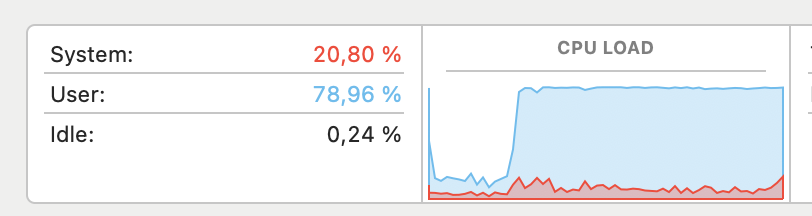

Multiprocessing cuts the time down to 4.5 hours

In [30]:
from multiprocess import Pool

def index_document(client: redis.Redis, prefix: str, word:str, meta):
  key = f"{prefix}:{word}"

  # create byte vectors for title and content
  with open(f"{embeddings_folder}/{meta['fileName']}") as f:
      word_vector = json.load(f)[0]["embedding"]
  word_embedding = np.array(word_vector, dtype=np.float32).tobytes()

  # replace list of floats with byte vectors

  client.hset(key, mapping={
      "word": word,
      "word_vector": word_embedding
  })

def process(x):
    index_document(redis_client, PREFIX, x[0], x[1])

if __name__ == '__main__':
    with Pool(8) as p:
        p.map(process, list(lookup.items())[:1000])

This is not enough, I don't have time today, so we´re making the dataset smaller

In [32]:
with open("word_selection.json") as f:
  selected_words = set(json.load(f)["data"])

We filter though our list of 2700 nouns. We randomly sample 1% of our total dictionary, leaving us with roughly 50/50 random sample / selected

Later modified to be mostly selected

In [406]:
import random

selection = []
for word in lookup:
  if random.randint(0,100) != 0:
    if not word in selected_words:
      continue
  selection.append(word)
len(selection)

5142

And we try again. This time we're done in 5 minutes, down from 18 hours

In [407]:
from multiprocess import Pool

def index_document(client: redis.Redis, prefix: str, word:str, meta):
  key = f"{prefix}:{word}"

  # create byte vectors for title and content
  with open(f"{embeddings_folder}/{meta['fileName']}") as f:
      word_vector = json.load(f)[meta["index"]]["embedding"]
  word_embedding = np.array(word_vector, dtype=np.float32).tobytes()

  # replace list of floats with byte vectors

  client.hset(key, mapping={
      "word": word,
      "word_vector": word_embedding
  })

def process(word):
    index_document(redis_client, PREFIX, word, lookup[word])

if __name__ == '__main__':
    with Pool(8) as p:
        p.map(process, selection)

In [272]:
from typing import List


def search_redis(
    redis_client: redis.Redis,
    user_query: str,
    index_name: str = INDEX_NAME,
    vector_field: str = "word_vector",
    return_fields: list = ["word", "vector_score"],
    hybrid_fields = "*",
    k: int = 20,
    print_results: bool = True,
) -> List[dict]:

    # Creates embedding vector from user query
    embedded_query = openai.embeddings.create(input=user_query,
                                            model="text-embedding-ada-002",
                                            ).data[0].embedding

    # Prepare the Query
    base_query = f'{hybrid_fields}=>[KNN {k} @{vector_field} $vector AS vector_score]'
    query = (
        Query(base_query)
         .return_fields(*return_fields)
         .sort_by("vector_score")
         .paging(0, k)
         .dialect(2)
    )
    params_dict = {"vector": np.array(embedded_query).astype(dtype=np.float32).tobytes()}

    # perform vector search
    results = redis_client.ft(index_name).search(query, params_dict)
    # print(results)
    # if print_results:
    #     for i, item in enumerate(results.docs):
    #         print(i)
    #         print(item)
    #         score = 1 - float(item.vector_score)
    #         print(f"{i}. {item.word} (Score: {round(score ,3) })")
    return results.docs

results = search_redis(redis_client, 'A walk on the park on a nice,sunny afternoon', k=50)
results

[Document {'id': 'doc:rhythm', 'payload': None, 'vector_score': '0.198038101196', 'word': 'rhythm'},
 Document {'id': 'doc:rhyme', 'payload': None, 'vector_score': '0.198038101196', 'word': 'rhyme'},
 Document {'id': 'doc:reward', 'payload': None, 'vector_score': '0.198038101196', 'word': 'reward'},
 Document {'id': 'doc:rhetorical', 'payload': None, 'vector_score': '0.198038101196', 'word': 'rhetorical'},
 Document {'id': 'doc:pail', 'payload': None, 'vector_score': '0.198745012283', 'word': 'pail'},
 Document {'id': 'doc:paint', 'payload': None, 'vector_score': '0.198745012283', 'word': 'paint'},
 Document {'id': 'doc:paddle', 'payload': None, 'vector_score': '0.198745012283', 'word': 'paddle'},
 Document {'id': 'doc:page', 'payload': None, 'vector_score': '0.198745012283', 'word': 'page'},
 Document {'id': 'doc:pack', 'payload': None, 'vector_score': '0.198745012283', 'word': 'pack'},
 Document {'id': 'doc:painful', 'payload': None, 'vector_score': '0.198745012283', 'word': 'painful

## Visualization of the results

[('aback', 0.782342910767), ('abaft', 0.782342910767), ('abandoned', 0.782342910767), ('abashed', 0.782342910767), ('aberrant', 0.782342910767), ('abhorrent', 0.782342910767), ('abiding', 0.782342910767), ('abject', 0.782342910767), ('ablaze', 0.782342910767), ('able', 0.782342910767), ('abnormal', 0.782342910767), ('aboard', 0.782342910767), ('aboriginal', 0.782342910767), ('abortive', 0.782342910767), ('payment', 0.78319722414), ('peace', 0.78319722414), ('peaceful', 0.78319722414), ('pear', 0.78319722414), ('peck', 0.78319722414), ('pedal', 0.78319722414), ('peel', 0.78319722414), ('peep', 0.78319722414), ('pack', 0.7918397188190001), ('paddle', 0.7918397188190001), ('page', 0.7918397188190001), ('pail', 0.7918397188190001), ('painful', 0.7918397188190001), ('painstaking', 0.7918397188190001), ('paint', 0.7918397188190001), ('pale', 0.7918397188190001), ('point', 0.792027294636), ('pointless', 0.792027294636), ('poised', 0.792027294636), ('poison', 0.792027294636), ('poke', 0.792027

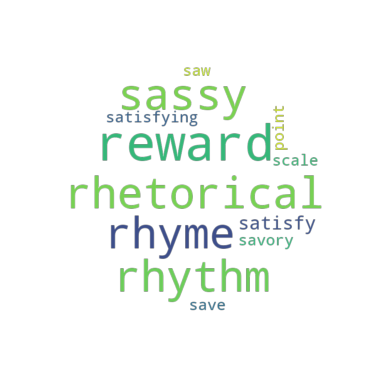

In [253]:
from PIL import Image
import matplotlib.pyplot as plt
from thoughtcloud import ThoughtCloud, ImageColorGenerator
def get_cloud():
  mask = np.array(Image.open("circle_small.png"))
  wordcloud = ThoughtCloud(mask=mask, background_color=None, scale=8, height=5000, width=5000, mode="RGBA")
  scores=[1-float(d["vector_score"]) for d in results]
  d=sorted(list(zip([d["word"] for d in results], scores)), key=lambda x: x[1], reverse=False)
  print(d)
  return wordcloud.generate_from_frequencies(frequencies=dict(d))
wc = get_cloud()
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

It seems that the search is not working very well. And the random sample words don't help

# Interpolating two texts

In [368]:
def get_embedding(word):
  try:
    meta = lookup[word]
    with open(f"{embeddings_folder}/{meta['fileName']}") as f:
      return np.array(json.load(f)[meta['index']]["embedding"])
  except:
    return np.array(openai.embeddings.create(input=word,
      model="text-embedding-ada-002",
    ).data[0].embedding)
  
print(get_embedding("cat"))
print(get_embedding("Walk in the Park"))

[-0.00710066 -0.01743051 -0.00966627 ... -0.01443552 -0.02329272
 -0.01422971]
[ 0.01308236 -0.00191145  0.02065771 ...  0.00077282 -0.01617526
 -0.01955631]


In [408]:
def search_redis_from_vector(
    redis_client: redis.Redis,
    vector_query: str,
    index_name: str = INDEX_NAME,
    vector_field: str = "word_vector",
    return_fields: list = ["word", "vector_score"],
    hybrid_fields = "*",
    k: int = 20,
) -> List[dict]:
    # Prepare the Query
    base_query = f'{hybrid_fields}=>[KNN {k} @{vector_field} $vector AS vector_score]'
    query = (
        Query(base_query)
         .return_fields(*return_fields)
         .sort_by("vector_score")
         .paging(0, k)
         .dialect(2)
    )
    params_dict = {"vector": np.array(vector_query).astype(dtype=np.float32).tobytes()}

    # perform vector search
    results = redis_client.ft(index_name).search(query, params_dict)
    return results.docs

def search_redis_with_radius(
    redis_client: redis.Redis,
    vector_query: str,
    index_name: str = INDEX_NAME,
    vector_field: str = "word_vector",
    return_fields: list = ["word", "vector_score"],
    radius: float = 20.0,
    k: int = 20,
) -> List[dict]:
    # Prepare the Query
    base_query = f'@{vector_field}:[VECTOR_RANGE {radius} $vector]=>{"{$YIELD_DISTANCE_AS: vector_score}"}'
    query = (
        Query(base_query)
         .return_fields(*return_fields)
         .sort_by("vector_score")
         .paging(0, k)
         .dialect(2)
    )
    params_dict = {"vector": np.array(vector_query).astype(dtype=np.float32).tobytes()}

    # perform vector search
    results = redis_client.ft(index_name).search(query, params_dict)
    return results.docs

### Average

In [409]:
avg_vector = (get_embedding("Go to the park") + get_embedding("Go to the lake") + get_embedding("businessman"))/3

In [410]:
search_redis_from_vector(redis_client,avg_vector, k=5)

[Document {'id': 'doc:park', 'payload': None, 'vector_score': '0.121286451817', 'word': 'park'},
 Document {'id': 'doc:visit', 'payload': None, 'vector_score': '0.12655299902', 'word': 'visit'},
 Document {'id': 'doc:playground', 'payload': None, 'vector_score': '0.131530463696', 'word': 'playground'},
 Document {'id': 'doc:shop', 'payload': None, 'vector_score': '0.132117092609', 'word': 'shop'},
 Document {'id': 'doc:zoo', 'payload': None, 'vector_score': '0.134637355804', 'word': 'zoo'}]

## Establish base points

In [411]:
# baseline = "You wake up on a sunny day, after a nice breakfast your partner asks you what you want to do today. It's your day off.\nYou answer: "
reference_concepts = {
  "The lake should be fun": {"pos": (25,25)},
  "Go to the park": {"pos": (25,75)},
  "Let's get lunch": {"pos": (75,25)},
  "Clean the house": {"pos": (75,75)}
}
for k in reference_concepts.keys():
  reference_concepts[k]["embedding"] = get_embedding(k) 

In [412]:
reference_concepts

{'The lake should be fun': {'pos': (25, 25),
  'embedding': array([ 0.01750815, -0.00588812,  0.01406518, ..., -0.0046512 ,
          0.00802085, -0.01911487])},
 'Go to the park': {'pos': (25, 75),
  'embedding': array([ 0.00967971,  0.01093302,  0.00332189, ..., -0.00605666,
         -0.00420711, -0.01735168])},
 "Let's get lunch": {'pos': (75, 25),
  'embedding': array([-0.01986605, -0.00420652,  0.01259143, ..., -0.01406136,
          0.00233157,  0.00112904])},
 'Clean the house': {'pos': (75, 75),
  'embedding': array([ 0.00900698,  0.01865731, -0.01855639, ..., -0.00762565,
          0.0055316 , -0.02017109])}}

In [413]:
import scipy
from sklearn.preprocessing import normalize

def dot_concept_interpolation(dot):
  positions = np.array(list([c["pos"] for c in reference_concepts.values()]))
  vectors = np.array(list([c["embedding"] for c in reference_concepts.values()]))
  point = np.array([dot])

  # Calculate
  distance = np.reciprocal(scipy.spatial.distance.cdist(point,positions)).clip(0, np.finfo(dtype=np.float64).max)
  distance = normalize(distance ** 1/2,)

  # Apply weights
  return np.matmul(distance,vectors)[0]

dot_concept_interpolation((40,40)),



(array([ 0.01168318,  0.00435886,  0.01115008, ..., -0.01423903,
         0.00695819, -0.02739371]),)

In [414]:
search_redis_from_vector(redis_client,
                         dot_concept_interpolation((25,25)),
                         k=5)

/var/folders/07/pjgm4z0s72vf2v1vm7q09pz00000gn/T/ipykernel_87779/2390275330.py:10: RuntimeWarning: divide by zero encountered in reciprocal
  distance = np.reciprocal(scipy.spatial.distance.cdist(point,positions)).clip(0, np.finfo(dtype=np.float64).max)


[Document {'id': 'doc:amberite', 'payload': None, 'vector_score': 'nan', 'word': 'amberite'},
 Document {'id': 'doc:boot', 'payload': None, 'vector_score': 'nan', 'word': 'boot'},
 Document {'id': 'doc:horn', 'payload': None, 'vector_score': 'nan', 'word': 'horn'},
 Document {'id': 'doc:myelopathic', 'payload': None, 'vector_score': 'nan', 'word': 'myelopathic'},
 Document {'id': 'doc:turkey', 'payload': None, 'vector_score': 'nan', 'word': 'turkey'}]

## Assemble Matrix

In [418]:
interpolation_results = {}
seen = set()
for i in range(0,200):
  x = random.random() * 100
  y = random.random() * 100
  vector = dot_concept_interpolation((x,y))
  results = search_redis_from_vector(redis_client, vector, k=20)
  for r in results:
    result = r.word
    if result in seen:
      continue
    interpolation_results[result] = (x,y)
    seen.add(result)
    break


In [419]:
print(seen)
print(interpolation_results)

{'house', 'nice', 'soup', 'cool', 'good', 'dinner', 'summer', 'party', 'wash', 'parkish', 'exciting', 'holiday', 'cook', 'spotless', 'food', 'zoo', 'rinse', 'lean', 'playground', 'brush', 'pleasant', 'busy', 'lick', 'clean', 'lake', 'bathe', 'clear', 'day', 'upbeat', 'visit', 'lettuce', 'dirty', 'greet', 'hungry', 'drink', 'motorboating', 'ski', 'boat', 'park', 'swim', 'meeting', 'tasty', 'playdates', 'entertaining', 'talk', 'houses', 'lunch', 'vacation', 'scrub', 'room', 'play', 'jog', 'enjoy', 'bath', 'tidy', 'school', 'yard', 'unclean', 'pray', 'bathroom', 'camp', 'eat', 'paddle', 'meal', 'hour', 'lunchroom', 'skate', 'wipe'}
{'park': (43.10849611008386, 89.63617187461553), 'clean': (99.6563055258362, 93.82260570552161), 'wash': (62.90575533356223, 92.8067856108768), 'lunch': (55.82491245382365, 51.9346081045211), 'dinner': (63.23934683905509, 0.18665626142509995), 'lunchroom': (89.0825764406642, 32.89007214155851), 'playdates': (50.626225591500926, 12.976457539426633), 'playground'

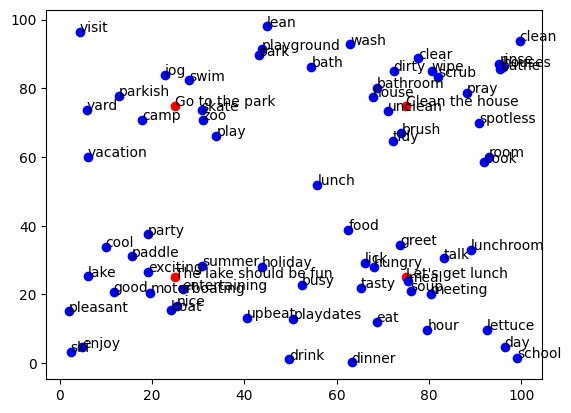

In [420]:
from matplotlib.axes import Axes
from matplotlib.axis import Axis


def plot_concepts(concepts, interpolated):
  fig, ax = plt.subplots()

  plot_position(ax, {k: concepts[k]["pos"]for k in concepts}, "red")
  # plot_position(ax, interpolated, "blue")

  plt.show()

def plot_position(ax, text_dict ,color):
  x,y = list(zip(*text_dict.values()))
  n=list(text_dict.keys())
  ax.scatter(x, y, color=color)

  for i, txt in enumerate(n):
      ax.annotate(txt, (x[i], y[i]))

plot_concepts(reference_concepts, interpolation_results)

In [422]:
with open("spaces/embedded_01.json", "w") as f:
  json.dump({**{k: reference_concepts[k]["pos"]for k in reference_concepts}, **interpolation_results}, f)